# Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import spacy
import random
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Bidirectional, Flatten

# Loading the Dataset

In [4]:
#loading dataset
df=pd.read_csv("LingualSense_dataset[1].csv",engine="python",encoding="UTF-8")
df.head()

,Text,Language
0,Klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


# Exploratory Data Analysis(EDA)

In [7]:
print(df['Language'])

0        Estonian
1         Swedish
2            Thai
3           Tamil
4           Dutch
           ...   
32331     Kannada
32332     Kannada
32333     Kannada
32334     Kannada
32335     Kannada
Name: Language, Length: 32336, dtype: object


In [9]:
df.shape

(32336, 2)

In [11]:
df.describe().T

,count,unique,top,freq
Text,32336,32116,haec commentatio automatice praeparata res ast...,48
Language,32336,30,English,2385


In [13]:
df["Language"].value_counts()

Language
English       2385
French        2014
Spanish       1819
Russian       1692
Dutch         1546
Arabic        1536
Turkish       1474
Tamil         1469
Hindi         1062
Romanian      1000
Persian       1000
Pushto        1000
Swedish       1000
Estonian      1000
Korean        1000
Chinese       1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Japanese      1000
Thai          1000
Portugeese     739
Italian        698
Sweedish       676
Malayalam      594
German         470
Danish         428
Kannada        369
Greek          365
Name: count, dtype: int64

In [15]:
df['Text']=df['Text'].fillna('')
df.isna().sum()

Text        0
Language    0
dtype: int64

In [17]:
print("\nDuplicate Entries:")
duplicates = df[df.duplicated()]
duplicates.head(10)


Duplicate Entries:


,Text,Language
410,bisby fa roskov yr orrell tm nicolson d paglin...,Indonesian
581,haec commentatio automatice praeparata res ast...,Latin
1012,haec commentatio automatice praeparata res ast...,Latin
1027,bisby fa roskov yr orrell tm nicolson d paglin...,Indonesian
1460,haec commentatio automatice praeparata res ast...,Latin
1594,haec commentatio automatice praeparata res ast...,Latin
1792,இக்கோயில் முதன்மைத் திருக்கோயில் என்ற வகைப்பாட...,Tamil
1878,haec commentatio automatice praeparata res ast...,Latin
2134,haec commentatio automatice praeparata res ast...,Latin
2159,haec commentatio automatice praeparata res ast...,Latin


In [19]:
print(f"\nDuplicate Count:{len(duplicates)}")


Duplicate Count:212


In [21]:
# removing Duplicates
df = df.drop_duplicates()

In [23]:
print("\nIs there any duplicates still found?:")
duplicates = df[df.duplicated()]
print(f"\nDuplicate Count:{len(duplicates)}")


Is there any duplicates still found?:

Duplicate Count:0


C:\Users\thota\AppData\Local\Temp\ipykernel_21596\2048806416.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Language',data=df,palette='Set1')


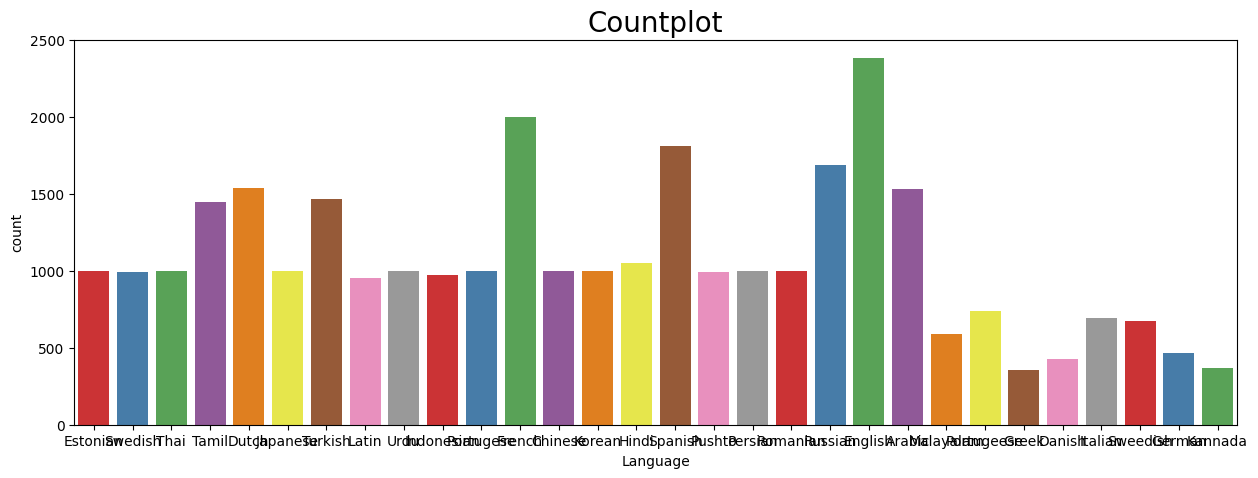

In [25]:
plt.figure(figsize=(15,5))
sns.countplot(x='Language',data=df,palette='Set1')
plt.title('Countplot',fontsize=20)
plt.show()

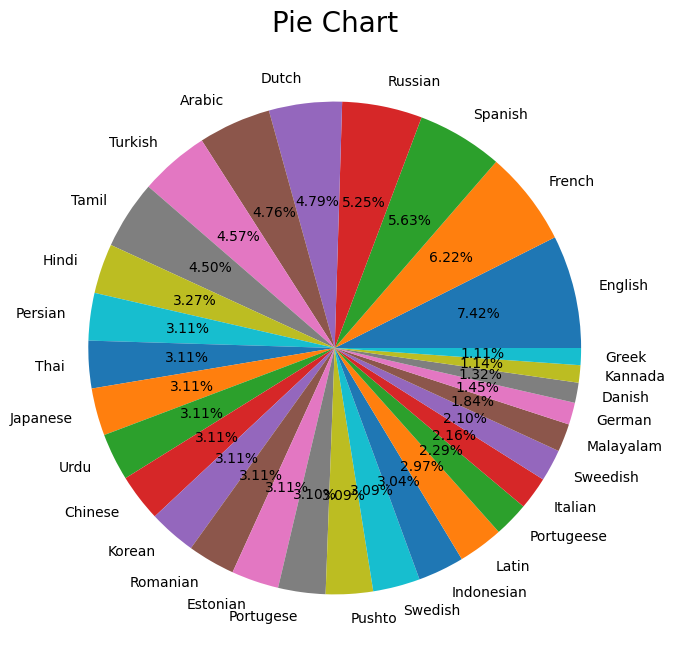

In [26]:
plt.figure(figsize=(8,8))
plt.pie(x = df['Language'].value_counts() ,autopct='%1.2f%%' ,labels=df['Language'].value_counts().index)
plt.title('Pie Chart',fontsize=20)
plt.show()

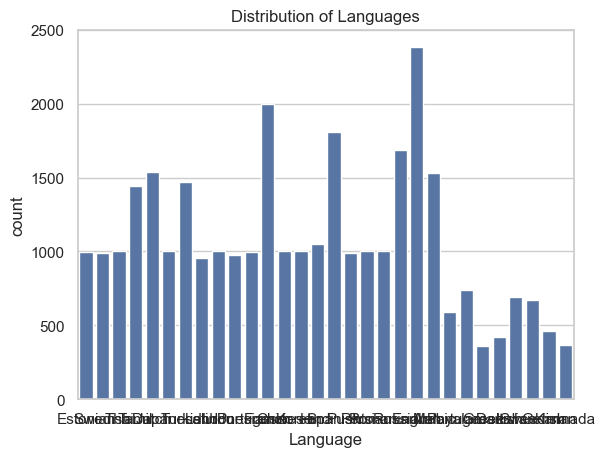

In [27]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["Language"])
plt.title("Distribution of Languages")
plt.show()

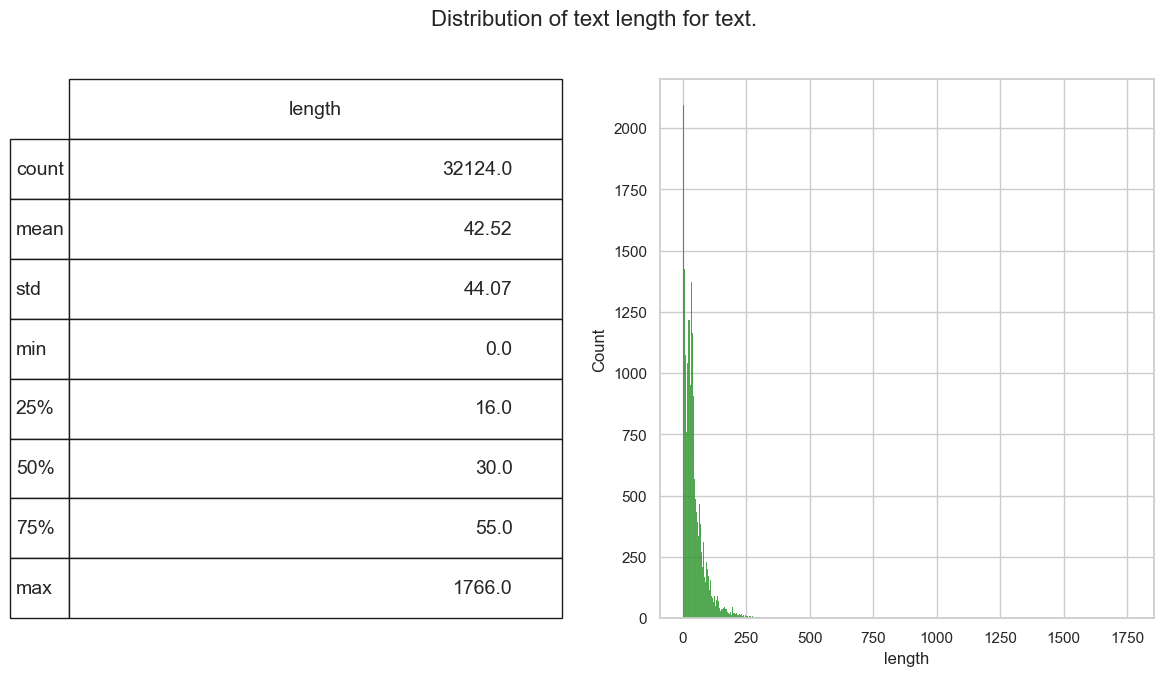

In [29]:
fig=plt.figure(figsize=(14,7))
df["length"]=df.Text.str.split().apply(len)
ax1=fig.add_subplot(122)
sns.histplot(df["length"],ax=ax1,color="green")
describe= df.length.describe().to_frame().round(2)


ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()


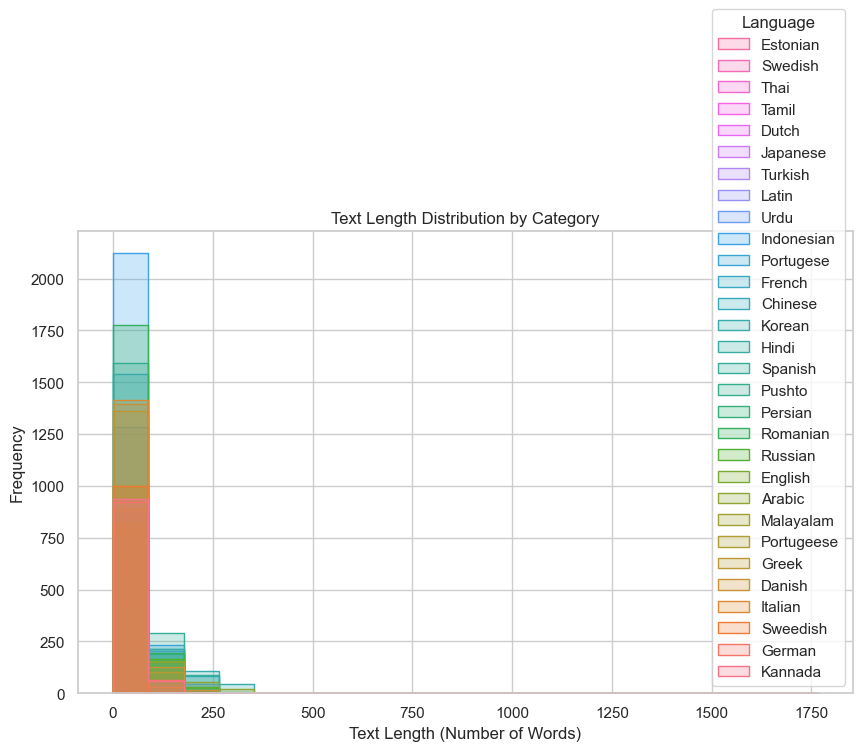

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='Language', bins=20, element='step')
plt.title("Text Length Distribution by Category")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Frequency")

unique_Language = df['Language'].unique()
plt.legend(title="Language", labels=unique_Language)

plt.show()

# Text Cleaning and Preprocessing

In [33]:
def clean_text(text):
    """
    Cleans the input text by:
    - Removing backslashes.
    - Replacing line breaks with a space.
    - Removing numeric characters.
    - Removing special characters and punctuations while preserving alphabetic characters (including Unicode letters) and spaces.
    - Reducing multiple spaces to a single space.
    - Stripping leading and trailing spaces.
    """
    text = re.sub(r'\\', '', text)  # Remove backslashes
    text = re.sub(r'\n', ' ', text)  # Replace line breaks with a space
    text = re.sub(r'\d+', '', text)  # Remove numeric characters
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)  # Remove special characters and punctuations
    text = re.sub(r'\s+', ' ', text).strip()  # Reduce multiple spaces to a single space and strip leading/trailing spaces
    return text

In [35]:
df['Text'] = df['Text'].apply(clean_text)

In [36]:
print(df.head(10))

                                                Text  Language  length
0  Klement gottwaldi surnukeha palsameeriti ning ...  Estonian      45
1  sebes joseph pereira thomas på eng the jesuits...   Swedish      27
2  ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...      Thai      14
3  வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...     Tamil      28
4  de spons behoort tot het geslacht haliclona en...     Dutch      28
5  エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...  Japanese       1
6  tsutinalar ingilizce tsuutina kanadada alberta...   Turkish      21
7  müller mox figura centralis circulorum doctoru...     Latin      24
8  برقی بار electric charge تمام زیرجوہری ذرات کی...      Urdu     117
9  シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...  Japanese       1


In [37]:
#Convert to lowercase
df['Text'] = df['Text'].str.lower()

In [38]:
print(df.head(10))

                                                Text  Language  length
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian      45
1  sebes joseph pereira thomas på eng the jesuits...   Swedish      27
2  ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...      Thai      14
3  வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...     Tamil      28
4  de spons behoort tot het geslacht haliclona en...     Dutch      28
5  エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...  Japanese       1
6  tsutinalar ingilizce tsuutina kanadada alberta...   Turkish      21
7  müller mox figura centralis circulorum doctoru...     Latin      24
8  برقی بار electric charge تمام زیرجوہری ذرات کی...      Urdu     117
9  シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...  Japanese       1


# Deep Learning Models Implementation 

In [41]:
label_encoder = LabelEncoder()
df['Language'] = label_encoder.fit_transform(df['Language'])

In [42]:
X = df['Text']
y = df['Language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

250559


In [46]:
max_length = 120
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [47]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## LSTM Model Training, Evaluation, and Prediction

In [33]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.3))
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
hist_lstm= model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 167s 400ms/step - accuracy: 0.3322 - loss: 2.3484 - val_accuracy: 0.8139 - val_loss: 0.6132
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 157s 391ms/step - accuracy: 0.8585 - loss: 0.4747 - val_accuracy: 0.9055 - val_loss: 0.3288
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 151s 376ms/step - accuracy: 0.9523 - loss: 0.1568 - val_accuracy: 0.9108 - val_loss: 0.3461
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.9832 - loss: 0.0726 - val_accuracy: 0.9156 - val_loss: 0.4169
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 152s 378ms/step - accuracy: 0.9957 - loss: 0.0236 - val_accuracy: 0.9149 - val_loss: 0.4415
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 155s 385ms/step - accuracy: 0.9979 - loss: 0.0135 - val_accuracy: 0.9136 - val_loss: 0.4110
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1168s 3s/step - accuracy: 0.9984 - loss: 0.0112 - val_accuracy: 0.9153 - val_loss: 0.4222
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 154s 383ms/step - accuracy: 0.9982 - loss

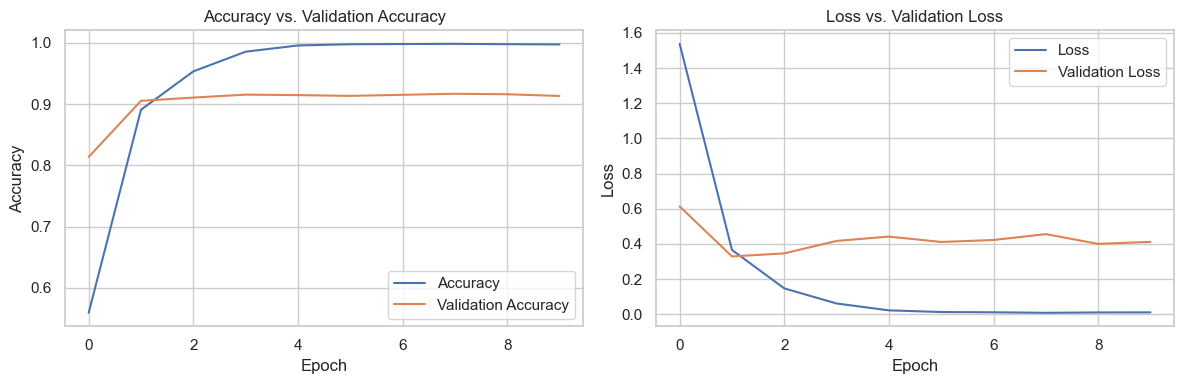

In [35]:
accuracy = hist_lstm.history['accuracy']
val_accuracy = hist_lstm.history['val_accuracy']
loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [36]:
hist_=pd.DataFrame(hist_lstm.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.559321,1.537991,0.813852,0.613246
1,0.890930,0.365749,0.905525,0.328762
2,0.953578,0.146906,0.910817,0.346122
3,0.985758,0.060979,0.915642,0.416905
4,0.995914,0.022019,0.914864,0.441469
5,0.997899,0.012429,0.913619,0.411045
6,0.998288,0.010979,0.915331,0.422238
7,0.998560,0.008045,0.917043,0.455611
8,0.998015,0.010093,0.916265,0.400240
9,0.997626,0.010524,0.913463,0.411527


In [37]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9133 - loss: 0.4188
Test Loss: 0.4115
Test Accuracy: 91.35%


In [38]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_lstm.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step
Classification Report:
               precision    recall  f1-score   support

      Arabic       1.00      0.95      0.97       299
     Chinese       0.44      0.89      0.59       212
      Danish       0.94      0.91      0.93        75
       Dutch       0.99      0.97      0.98       327
     English       0.93      0.97      0.95       468
    Estonian       0.99      0.95      0.97       195
      French       0.98      0.97      0.98       398
      German       0.91      0.92      0.92        93
       Greek       0.94      0.91      0.93        68
       Hindi       1.00      0.99      1.00       200
  Indonesian       1.00      0.99      0.99       216
     Italian       1.00      0.88      0.93       106
    Japanese       0.17      0.08      0.11       215
     Kannada       0.87      0.89      0.88        80
      Korean       0.99      0.96      0.98       187
       Latin       0.97      0.96      0.96       179
   Malayalam  

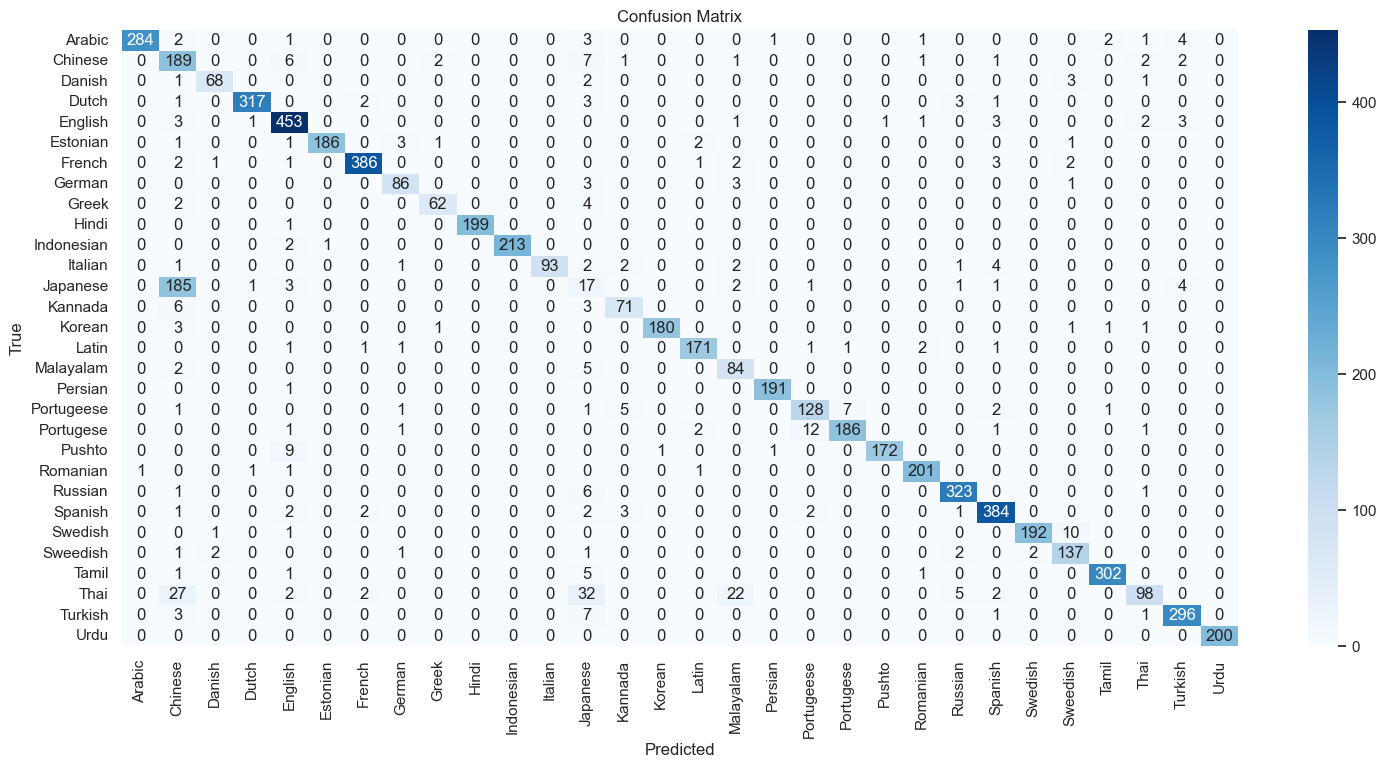

In [39]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
def predict_languages(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts: 
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_language = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_language, probabilities.max()))

    return predictions

texts = [
     "مرحبًا بك في عالم اللغة والتواصل. اللغة هي جسر يجمع الناس من مختلف الثقافات والخلفيات. عندما تتعلم لغة جديدة، فإنك تفتح بابًا لفهم الآخرين بشكل أعمق وتوسيع آفاقك.",
     "语言是人与人之间沟通的重要工具。通过学习一种新语言，我们可以更好地了解不同文化的背景和习俗，同时扩大我们的国际视野。",
     "Sprog er en nøgle til forståelse og forbindelse mellem mennesker. Når vi lærer et nyt sprog, åbner vi døre til nye kulturer og oplevelser, der kan berige vores liv.",
     "Taal is een krachtig middel om mensen met elkaar te verbinden. Door een nieuwe taal te leren, kunnen we de wereld om ons heen beter begrijpen en verschillende perspectieven ontdekken.",
     "Hand gesture recognition plays a crucial role in human-computer interaction and sign language interpretation. The objective of this proposed system is to develop a hand gesture recognition system for controlling a media player.",
     "Keel on võimas tööriist inimeste vahelise suhtluse jaoks. Uue keele õppimine avab ukse uutele võimalustele ja aitab mõista erinevaid kultuure.",
     "La langue est un outil puissant pour établir des liens entre les gens. Apprendre une nouvelle langue permet de découvrir de nouvelles cultures et d'élargir ses horizons.",
   "Sprache ist ein wichtiger Schlüssel zur Verbindung von Menschen. Das Erlernen einer neuen Sprache eröffnet die Möglichkeit, andere Kulturen zu verstehen und die Welt anders zu sehen.",
     "Η γλώσσα είναι ένα εργαλείο που συνδέει τους ανθρώπους. Μαθαίνοντας μια νέα γλώσσα, ανοίγουμε πόρτες σε διαφορετικούς πολιτισμούς και εμπειρίες.",
    "गूगल विश्वभर में फैले अपने डाटा-केन्द्रों से दस लाख से ज़्यादा सर्वर चलाता है और दस अरब से ज़्यादा खोज-अनुरोध तथा चौबीस पेटाबाईट उपभोक्ता-सम्बन्धी जानकारी (डाटा) संसाधित करता है।",
     "Bahasa adalah alat penting untuk menghubungkan orang dari berbagai latar belakang. Dengan mempelajari bahasa baru, kita dapat memahami budaya lain dengan lebih baik dan memperluas wawasan kita.",
   "La lingua è uno strumento fondamentale per connettere le persone. Imparare una nuova lingua apre le porte a nuove culture e modi di pensare.",
     "言語は人と人をつなぐ架け橋です。新しい言語を学ぶことで、異なる文化や伝統を深く理解し、視野を広げることができます。",
     "ಭಾಷೆ ಜನರನ್ನು ಸಂಪರ್ಕಿಸಲು ಒಂದು ಮುಖ್ಯ ಸಾಧನವಾಗಿದೆ. ಹೊಸ ಭಾಷೆಯನ್ನು ಕಲಿಯುವುದರಿಂದ ನಮ್ಮ ಅರಿವು ಹೆಚ್ಚಾಗುತ್ತದೆ ಮತ್ತು ವಿವಿಧ ಸಂಸ್ಕೃತಿಗಳನ್ನು ಒಳಗೊಂಡು ನೋಡಲು ಸಾಧ್ಯವಾಗುತ್ತದೆ.",
     "언어는 사람들을 연결하는 중요한 도구입니다. 새로운 언어를 배우면 다른 문화와 전통을 깊이 이해하고 시야를 넓힐 수 있습니다.",
     "Lingua est instrumentum humanitatis ad coniungendos populos. Novam linguam discendo, portas aperimus ad culturas varias et novas perspective.",
    "ഭാഷ മനുഷ്യരെ ബന്ധിപ്പിക്കുന്ന ഒരു പ്രധാന ഉപകരണമാണ്. ഒരു പുതിയ ഭാഷ പഠിക്കുന്നത്, നിങ്ങൾക്ക് വിവിധ സാംസ്കാരികങ്ങളെ കുറിച്ച് കൂടുതൽ മനസിലാക്കാനും നിങ്ങളുടെ കാഴ്ചപ്പാട് വികസിപ്പിക്കാനും സഹായിക്കുന്നു.",
    "زبان ابزار مهمی برای برقراری ارتباط بین افراد است. یادگیری یک زبان جدید درک عمیق‌تری از فرهنگ‌ها و سنت‌های مختلف به ما می‌دهد.",
   "A linguagem é uma ponte que conecta pessoas de culturas diferentes. Aprender um novo idioma amplia seus horizontes e aprofunda sua compreensão do mundo.",
     "ژبه د خلکو تر منځ د اړیکو لپاره یو مهم وسیله ده. د یوې نوې ژبې زده کړه د مختلفو کلتورونو او دودونو د ښه پوهیدو لپاره دروازې پرانیزي.",
     "Limba este un mijloc esențial de conectare între oameni. Învățarea unei limbi noi deschide uși către noi culturi și perspective.",
     "Язык является важным инструментом общения между людьми. Изучая новый язык, мы открываем для себя новые культуры и расширяем кругозор.",
    "El lenguaje es un puente que conecta a las personas de diferentes culturas. Aprender un nuevo idioma no solo amplía tus horizontes, sino que también profundiza tu comprensión del mundo.",
     "Språk är en bro som förenar människor från olika kulturer. Att lära sig ett nytt språk öppnar dörrar till nya upplevelser och förståelse.",
     "மொழி மனிதர்களை இணைக்கும் ஒரு முக்கிய சாதனமாகும். புதிய மொழியை கற்றுக்கொள்வதால் நாம் பல்வேறு பண்பாடுகளை புரிந்துகொள்ள முடியும்.",
    "ภาษาเป็นเครื่องมือสำคัญที่เชื่อมโยงผู้คนจากหลากหลายวัฒนธรรม การเรียนรู้ภาษาที่สามช่วยขยายมุมมองและความเข้าใจต่อโลกและวัฒนธรรมอื่น ๆ",
     "Dil, farklı kültürlerden insanları birleştiren bir köprüdür. Yeni bir dil öğrenmek, ufkunuzu genişletir ve dünyayı daha iyi anlamanızı sağlar.",
    "زبان لوگوں کو جوڑنے کا ایک اہم ذریعہ ہے۔ نئی زبان سیکھنا نہ صرف آپ کی سمجھ کو گہرا کرتا ہے بلکہ مختلف ثقافتوں اور روایات کو سمجھنے کا موقع بھی فراہم کرتا ہے۔"
]
# "Arabic":
# "Chinese":
# "Danish":
# "Dutch":
# "English":
# "Estonian":
# "French":
#  "German":
# "Greek":
#  "Hindi":
# "Indonesian":
#  "Italian": 
# "Japanese":
# "Kannada":
# "Korean":
# "Latin":
# "Malayalam":
#  "Persian":
#   "Portuguese":
# "Pushto":
# "Romanian":
# "Russian":
# "Spanish"
# "Swedish":
# "Tamil":
#  "Thai":
# "Turkish":
#  "Urdu":


predicted_languages = predict_languages( texts, model_lstm, tokenizer, max_length, label_encoder)

for text, (predicted_language, probability) in zip(texts, predicted_languages):
    print(f"Text: '{text}'")
    print(f"Predicted Language: {predicted_language}")
    print(f"Probability of {predicted_language}: {probability:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [41]:
import pickle

In [42]:
filename = "trainedmodel.sav"
pickle.dump(model_lstm,open(filename,"wb"))

In [43]:
tokenizerfilename="savedtokenizer.pkl"
pickle.dump(tokenizer,open(tokenizerfilename,"wb"))

# loading saved model

In [45]:
loaded_model= pickle.load(open("trainedmodel.sav","rb"))

In [46]:
loaded_tokenizer= pickle.load(open("savedtokenizer.pkl","rb"))

In [47]:
def predict_languages(texts, max_length, label_encoder):
    predictions = []

    for text in texts: 
        cleaned_text = clean_text(text)
        sequences = loaded_tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = loaded_model.predict(padded_sequences)[0]
        predicted_language = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_language, probabilities.max()))

    return predictions

texts = [
     "مرحبًا بك في عالم اللغة والتواصل. اللغة هي جسر يجمع الناس من مختلف الثقافات والخلفيات. عندما تتعلم لغة جديدة، فإنك تفتح بابًا لفهم الآخرين بشكل أعمق وتوسيع آفاقك.",
     "语言是人与人之间沟通的重要工具。通过学习一种新语言，我们可以更好地了解不同文化的背景和习俗，同时扩大我们的国际视野。",
     "Sprog er en nøgle til forståelse og forbindelse mellem mennesker. Når vi lærer et nyt sprog, åbner vi døre til nye kulturer og oplevelser, der kan berige vores liv.",
     "Taal is een krachtig middel om mensen met elkaar te verbinden. Door een nieuwe taal te leren, kunnen we de wereld om ons heen beter begrijpen en verschillende perspectieven ontdekken.",
     "Hand gesture recognition plays a crucial role in human-computer interaction and sign language interpretation. The objective of this proposed system is to develop a hand gesture recognition system for controlling a media player",
     "Keel on võimas tööriist inimeste vahelise suhtluse jaoks. Uue keele õppimine avab ukse uutele võimalustele ja aitab mõista erinevaid kultuure.",
     "La langue est un outil puissant pour établir des liens entre les gens. Apprendre une nouvelle langue permet de découvrir de nouvelles cultures et d'élargir ses horizons.",
   "Sprache ist ein wichtiger Schlüssel zur Verbindung von Menschen. Das Erlernen einer neuen Sprache eröffnet die Möglichkeit, andere Kulturen zu verstehen und die Welt anders zu sehen.",
     "Η γλώσσα είναι ένα εργαλείο που συνδέει τους ανθρώπους. Μαθαίνοντας μια νέα γλώσσα, ανοίγουμε πόρτες σε διαφορετικούς πολιτισμούς και εμπειρίες.",
    "भाषा लोगों को जोड़ने का एक महत्वपूर्ण साधन है। एक नई भाषा सीखने से न केवल हमारी समझ बढ़ती है, बल्कि हमें अलग-अलग संस्कृतियों और परंपराओं को गहराई से समझने का मौका भी मिलता है।",
     "Bahasa adalah alat penting untuk menghubungkan orang dari berbagai latar belakang. Dengan mempelajari bahasa baru, kita dapat memahami budaya lain dengan lebih baik dan memperluas wawasan kita.",
   "La lingua è uno strumento fondamentale per connettere le persone. Imparare una nuova lingua apre le porte a nuove culture e modi di pensare.",
     "言語は人と人をつなぐ架け橋です。新しい言語を学ぶことで、異なる文化や伝統を深く理解し、視野を広げることができます。",
     "ಭಾಷೆ ಜನರನ್ನು ಸಂಪರ್ಕಿಸಲು ಒಂದು ಮುಖ್ಯ ಸಾಧನವಾಗಿದೆ. ಹೊಸ ಭಾಷೆಯನ್ನು ಕಲಿಯುವುದರಿಂದ ನಮ್ಮ ಅರಿವು ಹೆಚ್ಚಾಗುತ್ತದೆ ಮತ್ತು ವಿವಿಧ ಸಂಸ್ಕೃತಿಗಳನ್ನು ಒಳಗೊಂಡು ನೋಡಲು ಸಾಧ್ಯವಾಗುತ್ತದೆ.",
     "언어는 사람들을 연결하는 중요한 도구입니다. 새로운 언어를 배우면 다른 문화와 전통을 깊이 이해하고 시야를 넓힐 수 있습니다.",
     "Lingua est instrumentum humanitatis ad coniungendos populos. Novam linguam discendo, portas aperimus ad culturas varias et novas perspective.",
    "ഭാഷ മനുഷ്യരെ ബന്ധിപ്പിക്കുന്ന ഒരു പ്രധാന ഉപകരണമാണ്. ഒരു പുതിയ ഭാഷ പഠിക്കുന്നത്, നിങ്ങൾക്ക് വിവിധ സാംസ്കാരികങ്ങളെ കുറിച്ച് കൂടുതൽ മനസിലാക്കാനും നിങ്ങളുടെ കാഴ്ചപ്പാട് വികസിപ്പിക്കാനും സഹായിക്കുന്നു.",
    "زبان ابزار مهمی برای برقراری ارتباط بین افراد است. یادگیری یک زبان جدید درک عمیق‌تری از فرهنگ‌ها و سنت‌های مختلف به ما می‌دهد.",
   "A linguagem é uma ponte que conecta pessoas de culturas diferentes. Aprender um novo idioma amplia seus horizontes e aprofunda sua compreensão do mundo.",
     "ژبه د خلکو تر منځ د اړیکو لپاره یو مهم وسیله ده. د یوې نوې ژبې زده کړه د مختلفو کلتورونو او دودونو د ښه پوهیدو لپاره دروازې پرانیزي.",
     "Limba este un mijloc esențial de conectare între oameni. Învățarea unei limbi noi deschide uși către noi culturi și perspective.",
     "Язык является важным инструментом общения между людьми. Изучая новый язык, мы открываем для себя новые культуры и расширяем кругозор.",
    "El lenguaje es un puente que conecta a las personas de diferentes culturas. Aprender un nuevo idioma no solo amplía tus horizontes, sino que también profundiza tu comprensión del mundo.",
     "Språk är en bro som förenar människor från olika kulturer. Att lära sig ett nytt språk öppnar dörrar till nya upplevelser och förståelse.",
     "மொழி மனிதர்களை இணைக்கும் ஒரு முக்கிய சாதனமாகும். புதிய மொழியை கற்றுக்கொள்வதால் நாம் பல்வேறு பண்பாடுகளை புரிந்துகொள்ள முடியும்.",
    "ภาษาเป็นเครื่องมือสำคัญที่เชื่อมโยงผู้คนจากหลากหลายวัฒนธรรม การเรียนรู้ภาษาที่สามช่วยขยายมุมมองและความเข้าใจต่อโลกและวัฒนธรรมอื่น ๆ",
     "Dil, farklı kültürlerden insanları birleştiren bir köprüdür. Yeni bir dil öğrenmek, ufkunuzu genişletir ve dünyayı daha iyi anlamanızı sağlar.",
    "زبان لوگوں کو جوڑنے کا ایک اہم ذریعہ ہے۔ نئی زبان سیکھنا نہ صرف آپ کی سمجھ کو گہرا کرتا ہے بلکہ مختلف ثقافتوں اور روایات کو سمجھنے کا موقع بھی فراہم کرتا ہے۔"
]
# "Arabic":
# "Chinese":
# "Danish":
# "Dutch":
# "English":
# "Estonian":
# "French":
#  "German":
# "Greek":
#  "Hindi":
# "Indonesian":
#  "Italian": 
# "Japanese":
# "Kannada":
# "Korean":
# "Latin":
# "Malayalam":
#  "Persian":
#   "Portuguese":
# "Pushto":
# "Romanian":
# "Russian":
# "Spanish"
# "Swedish":
# "Tamil":
#  "Thai":
# "Turkish":
#  "Urdu":




predicted_languages = predict_languages( texts, max_length, label_encoder)

for text, (predicted_language, probability) in zip(texts, predicted_languages):
    print(f"Text: '{text}'")
    print(f"Predicted Language: {predicted_language}")
    print(f"Probability of {predicted_language}: {probability:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━